In [11]:
import os
import torch
import pandas as pd
from loguru import logger
from datasets import EvalDataset
from torch.utils.data.dataloader import DataLoader
import timm
from sklearn.metrics import accuracy_score, f1_score
import warnings
import yaml
from utils import plot_confusion_matrix

In [8]:
with open("/home/sebastien/Documents/projects/solafune-finding-mining-sites/training_prediction/2024_03_03_19_30_16/training_config.json", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        logger.info(exc)

In [83]:
PREDICTION_DIR = config['prediction_dir']
MODEL_ARCHITECTURE = config['model_architecture']
PRETRAINED = config['pretrained']
RESIZE = config['resize']
IMAGE_NET_NORMALIZE = config['image_net_normalize']
PREPROCESSING = config['preprocessing']
NUMBER_KFOLD = config['number_kfold']
DATA_AUGMENTATION = config['data_augmentation']
SEED = config['seed']
LR = float(config['lr'])
BATCH_SIZE = config['batch_size']
NUM_EPOCHS = config['epochs']
GPU_DEVICE = config['gpu_device']
LOSS_FUNC = config['loss']
AUTO_EVAL = config['auto_eval']
prediction_dir = "/home/sebastien/Documents/projects/solafune-finding-mining-sites/training_prediction/2024_03_03_19_30_16"
list_dir = os.listdir(prediction_dir)
models_path = [file for file in list_dir if file.endswith('.pth')]

2024-03-03 20:38:58.357 | INFO     | __main__:<module>:7 - model_0: 0_model.pth
2024-03-03 20:38:58.399 | INFO     | eval:auto_eval:34 - ==> Loading checkpoint '/home/sebastien/Documents/projects/solafune-finding-mining-sites/training_prediction/2024_03_03_19_30_16/0_model.pth'
2024-03-03 20:38:58.698 | INFO     | eval:auto_eval:41 - Model is on Cuda: True
2024-03-03 20:39:01.655 | INFO     | eval:auto_eval:75 - EVALUATION: Accuracy 0.8951612903225806 - F1-score: 0.7450980392156863
2024-03-03 20:39:01.656 | INFO     | eval:auto_eval:76 - Done
2024-03-03 20:39:01.658 | INFO     | __main__:<module>:7 - model_1: 4_model.pth
2024-03-03 20:39:01.693 | INFO     | eval:auto_eval:34 - ==> Loading checkpoint '/home/sebastien/Documents/projects/solafune-finding-mining-sites/training_prediction/2024_03_03_19_30_16/4_model.pth'
2024-03-03 20:39:01.984 | INFO     | eval:auto_eval:41 - Model is on Cuda: True
2024-03-03 20:39:04.908 | INFO     | eval:auto_eval:75 - EVALUATION: Accuracy 0.895161290322

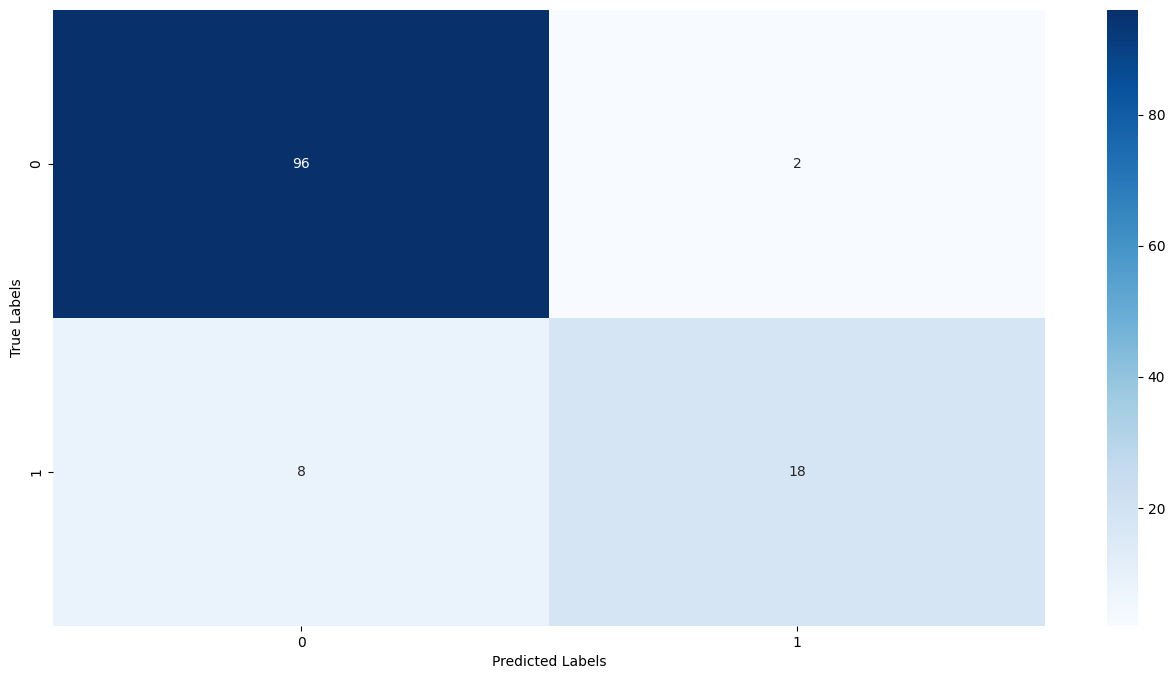

In [27]:
from eval import auto_eval

df_val = pd.DataFrame()
for i in range(len(models_path)):

    model_path = os.path.join(prediction_dir, models_path[i])
    logger.info(f"model_{i}: {models_path[i]}")
    preds_eval, targets_eval = auto_eval(model_path=model_path,
                                         model_architecture=MODEL_ARCHITECTURE,
                                         preprocessing=PREPROCESSING,
                                         resize=RESIZE,
                                         normalize=IMAGE_NET_NORMALIZE,
                                         save_path=prediction_dir)
    model_name = f"model_{i}"
    df_val[model_name] = np.stack(preds_eval, axis=0 ).flatten()

df_val['majority'] = df_val.mode(axis=1)[0]
df_val['target'] = np.stack(targets_eval, axis=0 ).flatten()
df_val.to_csv(os.path.join(prediction_dir,'ensemble_model.csv'))
# Confusion matrix of the ensemble model
ensemble_pred = df_val['majority'].values
ensemble_pred = [arr.astype(int) for arr in ensemble_pred]
plot_confusion_matrix(ensemble_pred, targets_eval, prediction_dir)
f1_eval = f1_score(ensemble_pred, targets_eval)
# logger.info(f"ENSEMBLE MODEL F1-SCORE: {f1_eval}")
# eval_metric = {'F1': f1_eval}
# save_path = os.path.join(prediction_dir, 'eval_metrics.json')

In [28]:
df_val

model_0  model_1  model_2  model_3  model_4  majority  target
0        0.0      0.0      0.0      0.0      0.0       0.0       0
1        0.0      0.0      0.0      0.0      0.0       0.0       0
2        0.0      0.0      0.0      0.0      0.0       0.0       0
3        0.0      0.0      0.0      0.0      0.0       0.0       0
4        0.0      0.0      0.0      0.0      0.0       0.0       0
..       ...      ...      ...      ...      ...       ...     ...
119      1.0      1.0      0.0      1.0      1.0       1.0       1
120      0.0      0.0      0.0      0.0      0.0       0.0       0
121      0.0      0.0      0.0      0.0      0.0       0.0       0
122      0.0      0.0      0.0      0.0      0.0       0.0       0
123      0.0      0.0      0.0      0.0      0.0       0.0       0

[124 rows x 7 columns]

In [56]:
df = pd.read_csv("/home/sebastien/Documents/projects/solafune-finding-mining-sites/data_splits/test_path.csv")
df = df.drop("target",axis=1)
dfs = pd.concat([df_val,df],axis=1)

In [58]:
dfs

model_0  model_1  model_2  model_3  model_4  majority  target  \
0        0.0      0.0      0.0      0.0      0.0       0.0       0   
1        0.0      0.0      0.0      0.0      0.0       0.0       0   
2        0.0      0.0      0.0      0.0      0.0       0.0       0   
3        0.0      0.0      0.0      0.0      0.0       0.0       0   
4        0.0      0.0      0.0      0.0      0.0       0.0       0   
..       ...      ...      ...      ...      ...       ...     ...   
119      1.0      1.0      0.0      1.0      1.0       1.0       1   
120      0.0      0.0      0.0      0.0      0.0       0.0       0   
121      0.0      0.0      0.0      0.0      0.0       0.0       0   
122      0.0      0.0      0.0      0.0      0.0       0.0       0   
123      0.0      0.0      0.0      0.0      0.0       0.0       0   

     Unnamed: 0                                         image_path  
0           120  /home/sebastien/Documents/projects/solafune-fi...  
1          1132  /home/sebastien/Documents/projects/solafune-fi...  
2           240  /home/sebastien/Documents/projects/solafune-fi...  
3           137  /home/sebastien/Documents/projects/solafune-fi...  
4           500  /home/sebastien/Documents/projects/solafune-fi...  
..          ...                                                ...  
119          20  /home/sebastien/Documents/projects/solafune-fi...  
120        1014  /home/sebastien/Documents/projects/solafune-fi...  
121         130  /home/sebastien/Documents/projects/solafune-fi...  
122         972  /home/sebastien/Documents/projects/solafune-fi...  
123         242  /home/sebastien/Documents/projects/solafune-fi...  

[124 rows x 9 columns]

In [59]:
# dfs = dfs.align(dfs, axis=1, copy=False)

# Filter the data where majority is different from target
filtered_df = dfs[dfs['majority'] != dfs['target']]

In [79]:
filtered_df

model_0  model_1  model_2  model_3  model_4  majority  target  \
28       1.0      0.0      1.0      1.0      1.0       1.0       0   
49       0.0      0.0      0.0      0.0      0.0       0.0       1   
57       0.0      0.0      0.0      0.0      0.0       0.0       1   
58       0.0      0.0      0.0      0.0      0.0       0.0       1   
66       0.0      0.0      0.0      1.0      0.0       0.0       1   
81       0.0      0.0      0.0      0.0      0.0       0.0       1   
89       1.0      0.0      0.0      0.0      0.0       0.0       1   
96       0.0      0.0      0.0      0.0      0.0       0.0       1   
106      0.0      0.0      0.0      0.0      0.0       0.0       1   
109      1.0      0.0      1.0      1.0      0.0       1.0       0   

     Unnamed: 0                                         image_path  
28          714  /home/sebastien/Documents/projects/solafune-fi...  
49          174  /home/sebastien/Documents/projects/solafune-fi...  
57          457  /home/sebastien/Documents/projects/solafune-fi...  
58          416  /home/sebastien/Documents/projects/solafune-fi...  
66         1094  /home/sebastien/Documents/projects/solafune-fi...  
81          171  /home/sebastien/Documents/projects/solafune-fi...  
89           89  /home/sebastien/Documents/projects/solafune-fi...  
96         1130  /home/sebastien/Documents/projects/solafune-fi...  
106         838  /home/sebastien/Documents/projects/solafune-fi...  
109         562  /home/sebastien/Documents/projects/solafune-fi...

In [80]:
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from loguru import logger 
import rioxarray as rxr
import natsort

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))


def image_preprocessing(image_path):

    image = rxr.open_rasterio(image_path, masked=False).values
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))
    return rgb_composite_n


def visualization(df,choice):
    
    

    image_path = df['image_path'].iloc[choice]
    image = rxr.open_rasterio(image_path, masked=False).values

    
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))
    # Create a figure with subplots to display the images
    plt.figure(figsize=(15, 5))
    
    # Display the images
    plt.imshow(rgb_composite_n)
    plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

 TARGET: 0
 PRED: 1
 PRED: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_714.tif


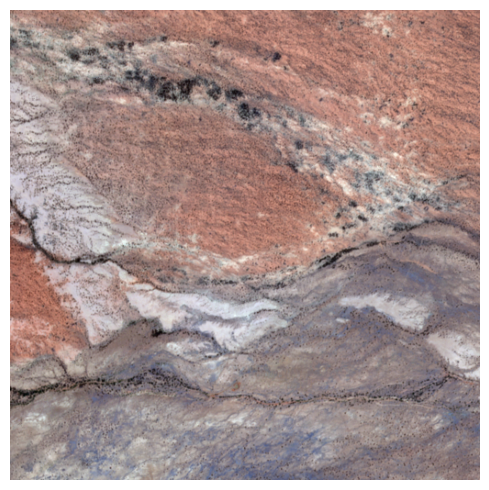

####

 TARGET: 1
 PRED: 0
 PRED: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_174.tif


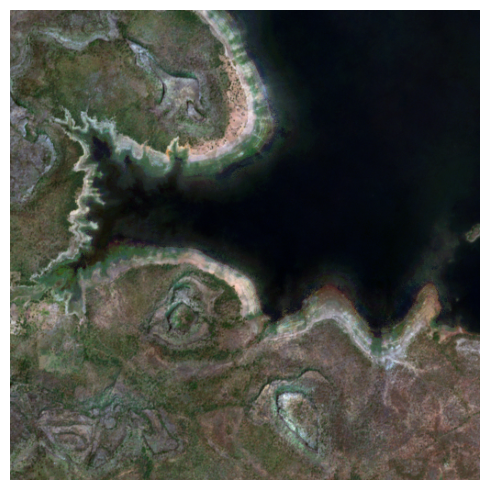

####

 TARGET: 1
 PRED: 0
 PRED: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_457.tif


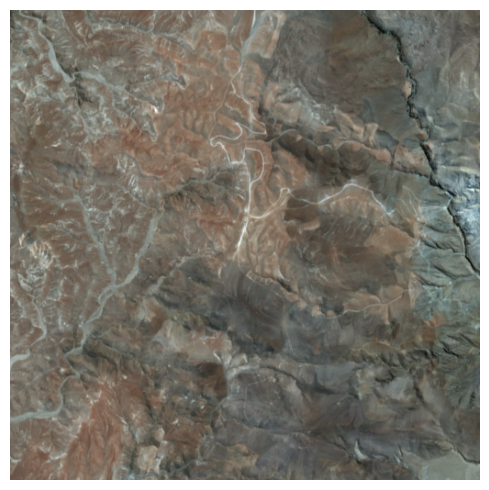

####

 TARGET: 1
 PRED: 0
 PRED: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_416.tif


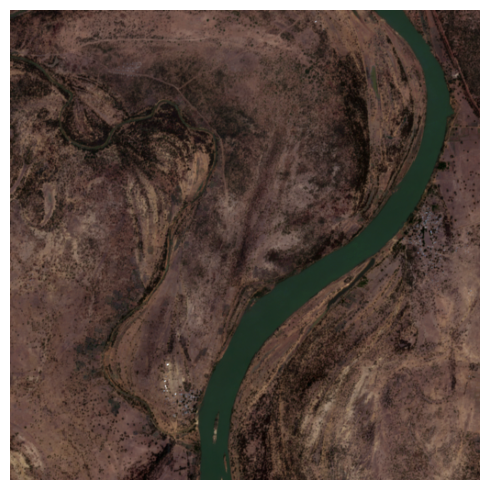

####

 TARGET: 1
 PRED: 0
 PRED: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_1097.tif


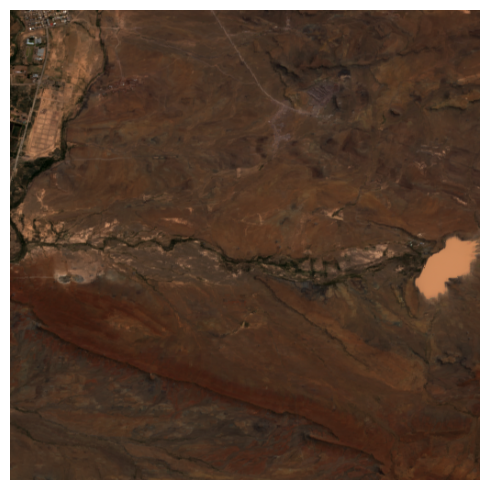

####

 TARGET: 1
 PRED: 0
 PRED: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_171.tif


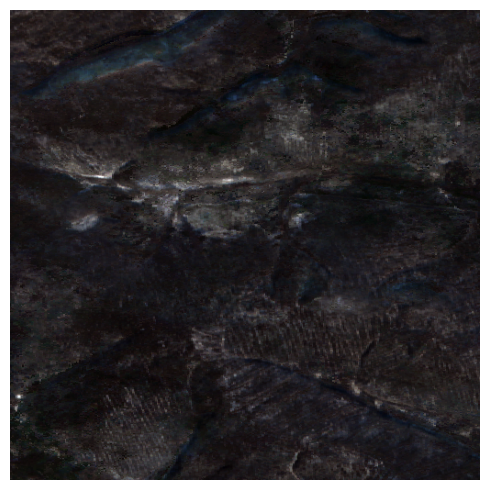

####

 TARGET: 1
 PRED: 0
 PRED: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_89.tif


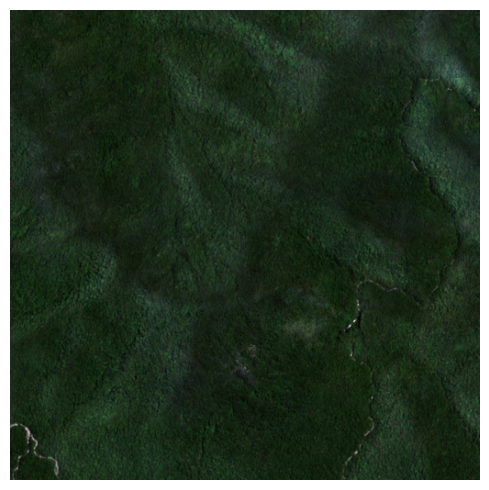

####

 TARGET: 1
 PRED: 0
 PRED: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_1133.tif


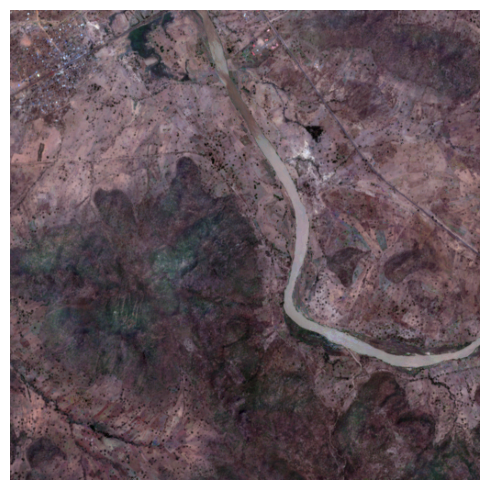

####

 TARGET: 1
 PRED: 0
 PRED: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_840.tif


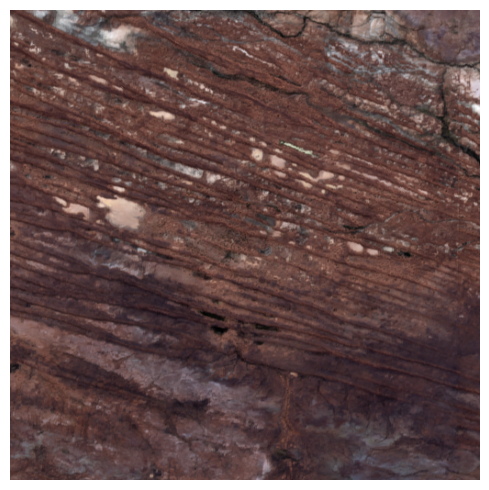

####

 TARGET: 0
 PRED: 1
 PRED: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_562.tif


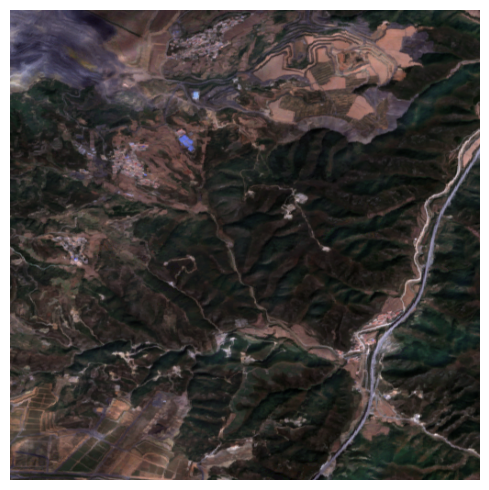

####



In [84]:
for i in range(len(filtered_df)):
    print(f" TARGET: {filtered_df.iloc[i]['target']}")
    print(f" PRED: {int(filtered_df.iloc[i]['majority'])}")
    print(f" PRED: {(filtered_df.iloc[i]['image_path'])}")
    visualization(dfs, choice=i)
    print("####")
    print("")

In [85]:
with open("/home/sebastien/Documents/projects/solafune-finding-mining-sites/training_prediction/2024_03_03_19_59_05/training_config.json", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        logger.info(exc)

In [86]:
PREDICTION_DIR = config['prediction_dir']
MODEL_ARCHITECTURE = config['model_architecture']
PRETRAINED = config['pretrained']
RESIZE = config['resize']
IMAGE_NET_NORMALIZE = config['image_net_normalize']
PREPROCESSING = config['preprocessing']
NUMBER_KFOLD = config['number_kfold']
DATA_AUGMENTATION = config['data_augmentation']
SEED = config['seed']
LR = float(config['lr'])
BATCH_SIZE = config['batch_size']
NUM_EPOCHS = config['epochs']
GPU_DEVICE = config['gpu_device']
LOSS_FUNC = config['loss']
AUTO_EVAL = config['auto_eval']
prediction_dir = "/home/sebastien/Documents/projects/solafune-finding-mining-sites/training_prediction/2024_03_03_19_59_05/"
list_dir = os.listdir(prediction_dir)
models_path = [file for file in list_dir if file.endswith('.pth')]

2024-03-03 21:15:31.334 | INFO     | __main__:<module>:7 - model_0: 0_model.pth
2024-03-03 21:15:32.046 | INFO     | eval:auto_eval:34 - ==> Loading checkpoint '/home/sebastien/Documents/projects/solafune-finding-mining-sites/training_prediction/2024_03_03_19_59_05/0_model.pth'
2024-03-03 21:15:32.452 | INFO     | eval:auto_eval:41 - Model is on Cuda: True
2024-03-03 21:15:37.171 | INFO     | eval:auto_eval:75 - EVALUATION: Accuracy 0.9596774193548387 - F1-score: 0.8936170212765957
2024-03-03 21:15:37.172 | INFO     | eval:auto_eval:76 - Done
2024-03-03 21:15:37.175 | INFO     | __main__:<module>:7 - model_1: 4_model.pth
2024-03-03 21:15:37.831 | INFO     | eval:auto_eval:34 - ==> Loading checkpoint '/home/sebastien/Documents/projects/solafune-finding-mining-sites/training_prediction/2024_03_03_19_59_05/4_model.pth'
2024-03-03 21:15:38.143 | INFO     | eval:auto_eval:41 - Model is on Cuda: True
2024-03-03 21:15:42.569 | INFO     | eval:auto_eval:75 - EVALUATION: Accuracy 0.935483870967

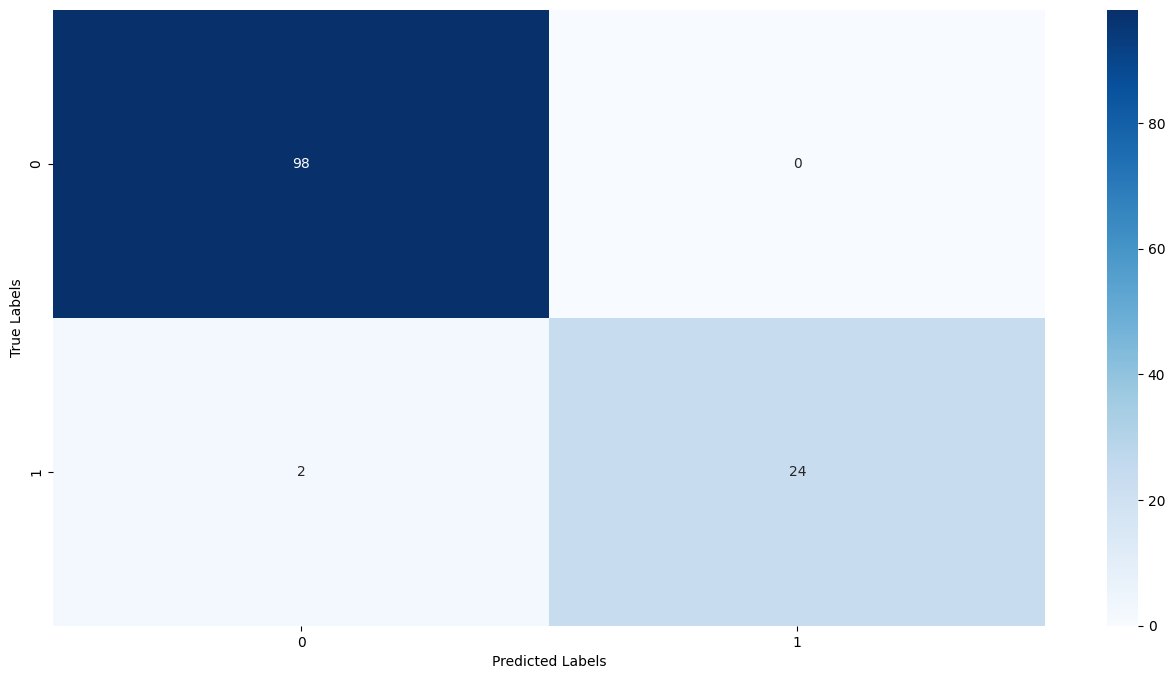

In [87]:
from eval import auto_eval

df_val = pd.DataFrame()
for i in range(len(models_path)):

    model_path = os.path.join(prediction_dir, models_path[i])
    logger.info(f"model_{i}: {models_path[i]}")
    preds_eval, targets_eval = auto_eval(model_path=model_path,
                                         model_architecture=MODEL_ARCHITECTURE,
                                         preprocessing=PREPROCESSING,
                                         resize=RESIZE,
                                         normalize=IMAGE_NET_NORMALIZE,
                                         save_path=prediction_dir)
    model_name = f"model_{i}"
    df_val[model_name] = np.stack(preds_eval, axis=0 ).flatten()

df_val['majority'] = df_val.mode(axis=1)[0]
df_val['target'] = np.stack(targets_eval, axis=0 ).flatten()
df_val.to_csv(os.path.join(prediction_dir,'ensemble_model.csv'))
# Confusion matrix of the ensemble model
ensemble_pred = df_val['majority'].values
ensemble_pred = [arr.astype(int) for arr in ensemble_pred]
plot_confusion_matrix(ensemble_pred, targets_eval, prediction_dir)
f1_eval = f1_score(ensemble_pred, targets_eval)
# logger.info(f"ENSEMBLE MODEL F1-SCORE: {f1_eval}")
# eval_metric = {'F1': f1_eval}
# save_path = os.path.join(prediction_dir, 'eval_metrics.json')

 TARGET: 1
 PRED: 0
 PRED: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_171.tif


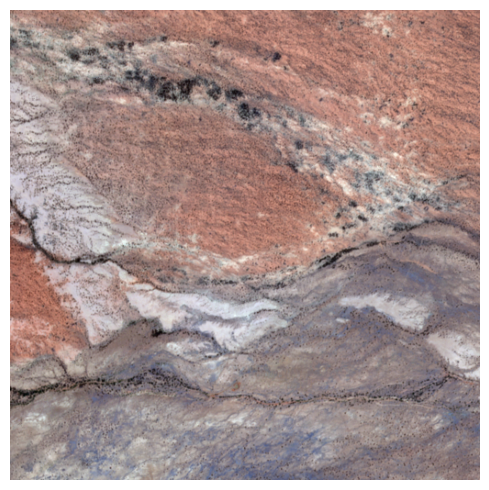

####

 TARGET: 1
 PRED: 0
 PRED: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_840.tif


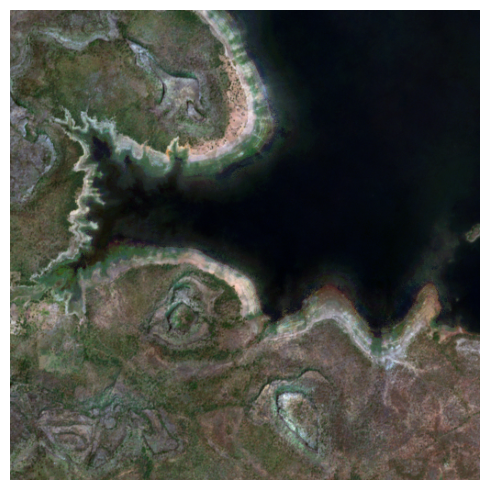

####



In [88]:
df = pd.read_csv("/home/sebastien/Documents/projects/solafune-finding-mining-sites/data_splits/test_path.csv")
df = df.drop("target",axis=1)
dfs = pd.concat([df_val,df],axis=1)
filtered_df = dfs[dfs['majority'] != dfs['target']]
for i in range(len(filtered_df)):
    print(f" TARGET: {filtered_df.iloc[i]['target']}")
    print(f" PRED: {int(filtered_df.iloc[i]['majority'])}")
    print(f" PRED: {(filtered_df.iloc[i]['image_path'])}")
    visualization(dfs, choice=i)
    print("####")
    print("")